<a href="https://colab.research.google.com/github/yeonghun00/stock_public/blob/main/index%20volatility%20analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import datetime
import ast

class Stock:
  def __init__(self, code):
    self.code = code
    self.headers = {'User-Agent' : 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/85.0.4183.121 Safari/537.36'}

  def get_price(self, start:int='20180501', end='', interval='day'):
    url ='https://api.finance.naver.com/siseJson.naver?symbol=' + self.code + ' &requestType=1&startTime=' \
    + start + '&endTime=' + end +  '&timeframe=' + interval

    result = requests.get(url)
    bs_obj = BeautifulSoup(result.content, "html.parser")
    b = bs_obj.get_text()
    for i in ['\n', '\t', "\\", ' ']:
      b = b.replace(i,'')

    data = np.array(ast.literal_eval(b)[1:])

    dic = {'Date':list(map(lambda x: datetime.datetime.strptime(str(x), '%Y%m%d'), data[:,0])), \
      'Open':np.array(data[:,1], int), 'High':np.array(data[:,2], int), 'Low':np.array(data[:,3], int),\
       'Close':np.array(data[:,4], int), 'Volume':np.array(data[:,5], int)}

    df = pd.DataFrame(data=dic)
    df = df.set_index('Date')
    return df
    
  def get_fundamental(self):
    url = 'https://finance.naver.com/item/main.nhn?code=' + self.code
    result = requests.get(url, headers = self.headers)
    bs_obj = BeautifulSoup(result.content, "html.parser")

    ths = bs_obj.find_all("th", {'scope':'col'})
    ths = [th.get_text() for th in ths][10:-22]
    dates = list(map(lambda x: x.translate(str.maketrans('','','\n\t, ')),ths))
    dates = list(map(lambda x: x + '(Y)', dates[:4])) + list(map(lambda x: x + '(M)', dates[4:]))

    tr = bs_obj.find_all("tbody")
    tds = tr[2].find_all('td')
    tds = [td.get_text() for td in tds]
    elements = list(map(lambda x: x.translate(str.maketrans('','','\n\t, ')),tds))
    elements = list(map(lambda x: float(x) if x.replace('.','').isdigit() else np.nan, elements))

    temp_dict = {}
    cnt = 0
    index = ['sales', 'operating profit', 'net income', 'operating margin', 'net margin', 'roe', 'debt ratio', 'quick ratio', \
    'reserve ratio', 'eps', 'per', 'bps', 'pbr', 'dividend per share', 'dividend yield ratio', 'dividend payout ratio']

    for i in dates:
      temp_dict[i] = elements[cnt::10]
      cnt += 1

    df = pd.DataFrame.from_dict(temp_dict)
    df = df.set_index([pd.Index(index)])
    return df

In [2]:
from dateutil import relativedelta

def get_next(date):
  date = datetime.datetime.strptime(date, '%Y%m%d')
  nextmonth = date + relativedelta.relativedelta(months=1)
  return str(nextmonth.strftime("%Y%m%d"))

In [3]:
dic = {}
start = '19900201'
end = get_next(start)

while end != '20210501':
  end = get_next(start)
  stock = Stock('KOSPI')
  dic[start] = stock.get_price(start, end)
  print('.', end='')
  start = end

.......................................................................................................................................................................................................................................................................................................................................................................................

In [4]:
# get volatility per month

for d in dic:
  dic[d]['Log returns'] = np.log(dic[d]['Close']/dic[d]['Close'].shift())
  volatility = dic[d]['Log returns'].std()*252**.5
  dic[d]['volatility'] = volatility

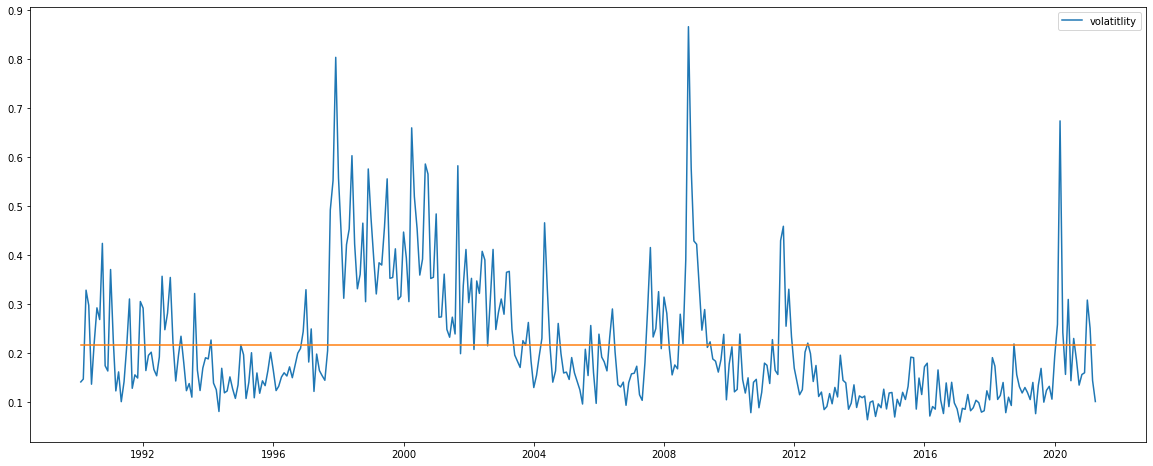

In [5]:
import matplotlib.pyplot as plt

y = [dic[x]['volatility'][0] for x in dic]
x = [datetime.datetime.strptime(x, '%Y%m%d') for x in list(dic)]
plt.figure(figsize=(20,8))
plt.plot(x, y)

# average
plt.plot(x, [sum([dic[x]['volatility'][0] for x in dic])/ len([dic[x]['volatility'][0] for x in dic])] * len(x))
plt.legend(['volatitlity'])
plt.show()